In [1]:
import sys
sys.path.append('../')

from fastai.text.all import *
from fastai.vision.all import *

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.policy_gradient import PolicyGradient, TRPO, PPO
from mrl.environment import *

/home/dmai/miniconda3/envs/mrl_f/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
# os.environ['DEFAULT_GPU'] = '1'
# os.environ['ncpus'] = '32'
torch.cuda.set_device(0)

In [3]:
# df = next(pd.read_csv('../../smiles_datasets/shard_0.csv', chunksize=2000000))
# df = pd.read_csv('../../smiles_datasets/shard_0.csv', usecols=['smiles'])
# df = pd.read_csv('../../smiles_datasets/chembl/chembl.csv')

df = pd.read_csv('../../smiles_datasets/single_frags.csv')

In [4]:
df = df[df.smiles.map(lambda x: 8<len(x)<=100)]
df = df[df.smiles.map(lambda x: not '.' in x)]
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

# vocab = FuncVocab(SELFIES_VOCAB, split_selfie,
#                   prefunc=smile_to_selfie, postfunc=selfie_to_smile)

In [5]:
df.shape

(5259476, 4)

In [6]:
df = df[df.weight<=200]

In [7]:
df.shape

(4881430, 4)

In [8]:
bs = 500

train_df = df.sample(frac=0.99, random_state=42)
valid_df = df[~(df.index.isin(train_df.index))]

In [9]:
gc.collect()

7

### LSTM LM

In [10]:
bs = 1000

train_ds = TextDataset(train_df.smiles.values, vocab)
valid_ds = TextDataset(valid_df.smiles.values, vocab)

train_dl = train_ds.dataloader(bs, shuffle=True, num_workers=32)
valid_dl = valid_ds.dataloader(bs, shuffle=False, num_workers=32)

dl = DataLoaders(train_dl, valid_dl)

In [12]:
x,y = next(iter(valid_dl))

In [13]:
(x==3).sum()

tensor(0)

In [11]:
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
lstm_drop = 0.
lin_drop = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
                lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

In [12]:
learn = Learner(dl, model, loss_func=CrossEntropyLossFlat())

In [13]:
learn = learn.to_fp16()

In [14]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.545603,0.557526,05:26
1,0.485897,0.495115,05:35
2,0.478868,0.482815,06:19
3,0.479775,0.477066,05:35
4,0.466156,0.473182,05:29
5,0.467747,0.470740,05:30
6,0.465840,0.468569,05:30
7,0.461515,0.467051,05:29
8,0.456835,0.466424,05:30
9,0.456735,0.466355,05:31


In [21]:
to_device(learn.model);

In [22]:
preds, _ = learn.model.sample_no_grad(512, 40)

In [23]:
smiles = []
for p in preds:
    try:
        smiles.append(vocab.reconstruct(p))
    except:
        pass

In [24]:
len(smiles)

512

In [25]:
mols = [to_mol(i) for i in smiles]

In [26]:
len([i is not None for i in mols])/len(mols)

1.0

In [15]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/lstm_lm_rgroup.pt')

In [16]:
len(vocab.unks)

0

In [11]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.431715,0.424578,06:05
1,0.305242,0.305236,06:07
2,0.267167,0.267981,06:11
3,0.247700,0.250198,06:10
4,0.236086,0.239726,06:08
5,0.225495,0.232297,06:08
6,0.215279,0.226874,06:10
7,0.208268,0.222736,06:09
8,0.202107,0.220999,06:09
9,0.198262,0.220829,06:12


In [12]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/lstm_lm_chembl.pt')

In [20]:
del learn.model
del learn
del model
del dl
torch.cuda.empty_cache()
gc.collect()

36925

### FP Conditional LSTM

In [9]:
train_ds = Vec_Recon_Dataset(train_df.smiles.values, vocab, ECFP6)
valid_ds = Vec_Recon_Dataset(valid_df.smiles.values, vocab, ECFP6)

train_dl = train_ds.dataloader(bs, shuffle=True, num_workers=6)
valid_dl = valid_ds.dataloader(bs, shuffle=False, num_workers=6)

dl = DataLoaders(train_dl, valid_dl)

In [10]:
encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
lstm_drop = 0.0
lin_drop = 0.0
bidir = False
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']

model = Conditional_LSTM_LM(encoder, d_vocab, d_embedding, d_hidden, d_latent, n_layers,
                lstm_drop, lin_drop, bidir, condition_hidden, condition_output, bos_idx)

In [11]:
class FPCallback(Callback):
    "Move data to CUDA device"
    def before_batch(self): 
        self.learn.xb = self.learn.xb[0]

In [12]:
learn = Learner(dl, model, loss_func=CrossEntropyLossFlat(), cbs=[FPCallback()])

In [13]:
learn = learn.to_fp16()

In [13]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [14]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt')

In [14]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,time
0,0.183373,0.178874,06:14
1,0.099193,0.090437,06:16
2,0.069625,0.064248,06:18
3,0.057161,0.057722,06:18


In [15]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/fp_cond_lstm_lm_chembl.pt')

In [16]:
del learn.model
del learn
del model
del dl
torch.cuda.empty_cache()
gc.collect()

14861

### LSTM Conditional LSTM

In [27]:
def lm_conditional_collate(batch, pad_idx):
    batch_tensor = batch_sequences(batch, pad_idx)
        
    output = ((batch_tensor[:,:-1], batch_tensor[:,:-1]), batch_tensor[:,1:])
        
    return output

collate = partial(lm_conditional_collate, pad_idx=vocab.stoi['pad'])

train_ds = TextDataset(train_df.smiles.values, vocab, collate_function=collate)
valid_ds = TextDataset(valid_df.smiles.values, vocab, collate_function=collate)

train_dl = train_ds.dataloader(bs, shuffle=True, num_workers=16)
valid_dl = valid_ds.dataloader(bs, shuffle=False, num_workers=16)

dl = DataLoaders(train_dl, valid_dl)

In [29]:
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
lstm_drop = 0.0
lin_drop = 0.0
bidir = False
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']

encoder = LSTM_Encoder(d_vocab, d_embedding, d_hidden, n_layers, d_latent)

model = Conditional_LSTM_LM(encoder, d_vocab, d_embedding, d_hidden, d_latent, n_layers,
                lstm_drop, lin_drop, bidir, condition_hidden, condition_output, bos_idx)

In [30]:
class InputCallback(Callback):
    "Move data to CUDA device"
    def before_batch(self): 
        self.learn.xb = self.learn.xb[0]

In [31]:
learn = Learner(dl, model, loss_func=CrossEntropyLossFlat(), cbs=[InputCallback()])

In [32]:
learn = learn.to_fp16()

In [33]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,time
0,0.249756,0.239581,08:16
1,0.174470,0.176938,08:17
2,0.133363,0.138449,08:19
3,0.110902,0.118550,08:26


In [34]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/lstm_cond_lstm_lm_chembl.pt')

In [35]:
del learn.model
del learn
del model
del dl
torch.cuda.empty_cache()
gc.collect()

14835

### FP VAE

In [8]:
train_ds = Vec_Recon_Dataset(train_df.smiles.values, vocab, ECFP6)
valid_ds = Vec_Recon_Dataset(valid_df.smiles.values, vocab, ECFP6)

train_dl = train_ds.dataloader(bs, shuffle=True, num_workers=8)
valid_dl = valid_ds.dataloader(bs, shuffle=False, num_workers=8)

dl = DataLoaders(train_dl, valid_dl)

In [9]:
d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
n_layers = 3
d_latent = 512
dec_drop=0.0
condition_hidden=True
condition_output=True
# condition_output=False
prior=None
bos_idx=0

model = MLP_VAE(d_vocab, d_embedding, encoder_d_in, encoder_dims, encoder_drops,
                d_hidden, n_layers, d_latent, dec_drop, condition_hidden, condition_output,
                prior, bos_idx)

In [10]:
class VAELoss():
    def __init__(self, weight=1.):
        self.ce = CrossEntropyLossFlat()
        self.weight = weight
        
    def __call__(self, inputs, targs):
        output, kl_loss = inputs
        return self.ce(output, targs) + self.weight*kl_loss

In [11]:
class FPVAECallback(Callback):
    "Move data to CUDA device"
    def before_batch(self): 
        self.learn.xb = self.learn.xb[0][::-1]

In [12]:
learn = Learner(dl, model, loss_func=VAELoss(weight=0.5), cbs=[FPVAECallback()])

In [13]:
learn = learn.to_fp16()

In [14]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.473384,0.467760,06:31
1,0.368316,0.362497,06:34
2,0.325149,0.322495,06:33
3,0.303006,0.299973,06:37
4,0.285036,0.286278,06:38
5,0.274156,0.277521,06:36
6,0.263959,0.269189,06:51
7,0.254487,0.264207,06:41
8,0.246742,0.261628,06:59
9,0.242931,0.261176,06:52


In [15]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/fp_vae_chembl_selfies.pt')

In [17]:
to_device(learn.model);

In [16]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,0.271926,0.274217,3:54:50


In [17]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/fp_vae_zinc.pt')

In [42]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,time
0,0.321686,0.320304,07:15
1,0.271788,0.272113,07:20
2,0.251283,0.252413,07:16
3,0.241727,0.246546,07:18


In [43]:
torch.save(learn.model.cpu().state_dict(), '../nbs/untracked_files/fp_vae_chembl.pt')

In [14]:
del learn.model
del learn
del model
del dl
torch.cuda.empty_cache()
gc.collect()

333

In [5]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [6]:
bs = 600

train_df = df.sample(frac=0.99, random_state=42)
valid_df = df[~(df.index.isin(train_df.index))]

In [8]:
train_ds = TextDataset(train_df.values, vocab)
valid_ds = TextDataset(valid_df.values, vocab)

train_dl = train_ds.dataloader(bs, shuffle=True, num_workers=16)
valid_dl = valid_ds.dataloader(bs, shuffle=False, num_workers=16)

dl = DataLoaders(train_dl, valid_dl)

In [27]:
x,y = next(iter(valid_dl))

In [28]:
gc.collect()

7

In [29]:
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
lstm_drop = 0.
lin_drop = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
                lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

In [30]:
learn = Learner(dl, model, loss_func=CrossEntropyLossFlat())

In [31]:
learn = learn.to_fp16()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0010000000474974513)

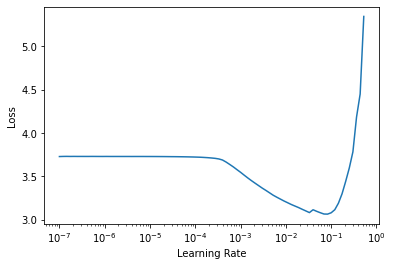

In [13]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,time


In [ ]:
torch.save(learn.model.state_dict(), '../nbs/untracked_files/lstm_lm_zinc.pt')

In [14]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.499856,0.489890,06:20
1,0.346255,0.345670,06:04
2,0.298225,0.297911,06:27
3,0.275423,0.277467,05:22
4,0.261902,0.265303,05:17
5,0.248770,0.256567,05:15
6,0.239067,0.249981,05:15
7,0.230261,0.245638,05:14
8,0.222779,0.243707,05:15
9,0.219667,0.243588,05:14


In [15]:
torch.save(learn.model.state_dict(), '../nbs/untracked_files/lstm_lm_chembl.pt')